# Data Augmentation

Data augmentation is a technique of artificially increasing the training set by creating modified versions of existing data. For example, in image processing, we can create new images by applying transformations like rotations, flips, or color adjustments to existing images. Data augmentation 
is a simple and powerful form of regularization that mitigates overfitting by creating diversity in training data. It helps machine learning models generalize better and perform well on unseen data, especially when the training data is limited or imbalanced. In this tutorial, we will demonstrate how to use data augmentation with a simple CNN trained for image classification.

In [1]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms.v2 as v2

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pathlib

## Preparation

In the previous tutorial, we have already downloaded and extracted the cats-vs-dogs dataset in the directory `.data/cats_vs_dogs/PetImages`. We will reuse this dataset with the same preprocessing steps.

In [2]:
IMAGE_SIZE = 128

# Image preprocessing
preprocess = v2.Compose([
    v2.ToImage(),
    v2.Resize(IMAGE_SIZE),
    v2.CenterCrop(IMAGE_SIZE),
    v2.ToDtype(torch.float32, scale=True),
])

# Load the full dataset
data_path = pathlib.Path(".data") / "cats_vs_dogs" / "PetImages"
dataset = torchvision.datasets.ImageFolder(data_path, transform=preprocess)

# Split the indices
train_idx, test_idx = train_test_split(range(len(dataset)), stratify=dataset.targets, test_size=0.2, shuffle=True, random_state=42)

# Create the subsets
train_ds = torch.utils.data.Subset(dataset, train_idx)
test_ds  = torch.utils.data.Subset(dataset, test_idx)

print(f"Train set: {len(train_ds)}")
print(f"Test set: {len(test_ds)}")

Train set: 18737
Test set: 4685


We will train a simple convolutional network on the cats-vs-dogs dataset. It is the same model as in the previous tutorial. To make this tutorial self-contained, we will copy the code below. But this is not the best practice. You should define the neural network in a separate Python file and import it.

In [3]:
class BaselineModel(torch.nn.Module):
    
    def __init__(self, image_size: int):
        super().__init__()
        ksize = 3
        self.conv1 = torch.nn.Conv2d(3, 32, ksize)
        self.conv2 = torch.nn.Conv2d(32, 64, ksize)
        self.conv3 = torch.nn.Conv2d(64, 128, ksize)
        self.conv4 = torch.nn.Conv2d(128, 128, ksize)
        flat_dim = self.__calc_dim(image_size)
        self.fc1 = torch.nn.Linear(flat_dim, 256)
        self.fc2 = torch.nn.Linear(256, 1)

    def forward(self, x):
        for conv in [self.conv1, self.conv2, self.conv3, self.conv4]:
            x = F.relu(conv(x))
            x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def __calc_dim(self, input_dim: int):
        """Returns the tensor size after the flatten layer."""
        n = input_dim
        for conv in [self.conv1, self.conv2, self.conv3, self.conv4]:
            n = n - conv.kernel_size[0] + 1 # CONV output size
            n = n // 2                      # POOL output size
        dim = n * n * self.conv4.out_channels
        return dim

## Transforms

TorchVision provides a list of [transforms](https://pytorch.org/vision/stable/transforms.html#v2-api-reference-recommended) that make it easy to manipulate images. These operations can be used to preprocess or augment images during training or inference of various computer vision tasks, such as image classification, detection, segmentation, video classification. Here are the key points to remember.

 - Transforms behave like a regular `torch.nn.Module` (in fact, most of them are).

 - Most transforms accept both PIL images and PyTorch tensors as input. 

 - Tensor images are expected to be in channel-first format, i.e., with shape *(Channels, Height, Width)*.
 
 - Most transforms accept a batch of tensor images with an arbitrary number of leading dimensions. 
 
 - The expected range of the values of a tensor image is implicitly defined by the data type.
   - Tensor images with a `float` data type are expected to have values in [0, 1].
   - Tensor images with a `uint8` data type  are expected to have values in [0, 255].
   - Tensor images with an integer data type are expected to have values in [0, MAX_VALUE].

 - A series of transforms can be chained together using the `Compose` class.

We already encountered several transforms in the previous tutorials. Perhaps the two most used transforms are [`ToImage`](https://pytorch.org/vision/main/generated/torchvision.transforms.v2.ToImage.html) and [`ToDtype`](https://pytorch.org/vision/main/generated/torchvision.transforms.v2.ToDtype.html). The first one converts a PIL image to a PyTorch tensor, whereas the second one converts the data type and range of a tensor.

```{note}
This [example](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html) illustrates the effect of various transforms provided by TorchVision.
```

### Augmentation pipeline

In this tutorial, we will use an augmentation pipeline that includes the following transforms.

 - [`RandomResizedCrop`](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.RandomResizedCrop.html) - Crop a random portion of the input image and resize it to a given size. The crop has a random area no larger than the given size, and a random aspect ratio between 3/4 and 4/3. 
 
 - [`RandomHorizontalFlip`](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.RandomHorizontalFlip.html) - Horizontally flip the input image with a given probability.
 
 - [`ColorJitter`](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.ColorJitter.html) - Randomly change the brightness, contrast, saturation and hue of the input image.

The figure below illustrates the augmentation pipeline that we are going to implement. Note that the horizontal flip and the color jitter are
skipped with a certain probability, based on a decision taken independently for each image in the batch. When a probability argument is not supported by a transform, which is the case for `ColorJitter`, we can use [`RandomApply`](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.RandomApply.html) to apply a transform with a given probability.

![Augmentation Pipeline](pics/augmentation_pipeline.jpg)

The code below defines the augmentation pipeline in PyTorch. Note that the pipeline includes the [`ToImage`](https://pytorch.org/vision/main/generated/torchvision.transforms.v2.ToImage.html) and [`ToDtype`](https://pytorch.org/vision/main/generated/torchvision.transforms.v2.ToDtype.html) transforms. This ensures that the input to the neural network is a PyTorch tensor with floating-point values in [0, 1].

In [4]:
augmentation = v2.Compose([
    v2.ToImage(),
    v2.RandomResizedCrop(IMAGE_SIZE),
    v2.RandomHorizontalFlip(),
    v2.RandomApply([v2.ColorJitter(0.2, 0.2, 0.2, 0.2)], p=0.2),
    v2.ToDtype(torch.float32, scale=True)
])

### Augmented training set

At the beginning of this tutorial, we have created a training set without data augmentation. We will now create a training set that includes data augmentation. The test set will remain the same.

In [5]:
# Load the full dataset with augmentation
augmented_dataset = torchvision.datasets.ImageFolder(data_path, transform=augmentation)

# Create the train set using the same indices as before
augmented_train_ds = torch.utils.data.Subset(augmented_dataset, train_idx)

Note that `ImageFolder` use lazy loading, which means that the images are loaded on-the-fly when they are accessed. The augmentation is hence applied on-the-fly during training. This is called "online data augmentation", which is the most common way to apply data augmentation in deep learning.

### Visualizing the augmented images

Let's visualize some images from the augmented training set to see the effect of the augmentation pipeline.

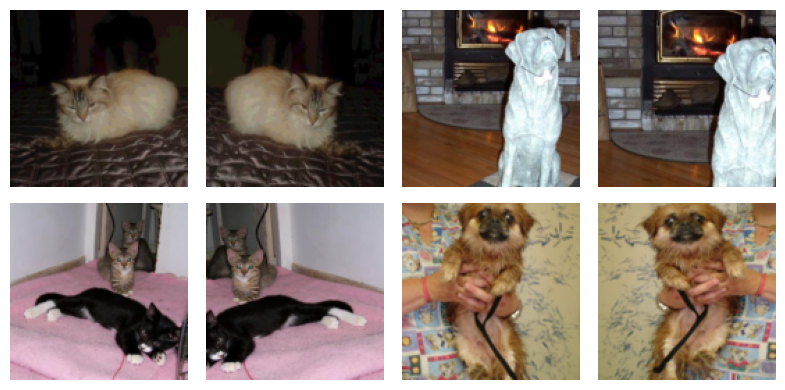

In [6]:
plt.figure(figsize=(8, 4), tight_layout=True)

for i in range(4):
    image, _ = train_ds[i]
    augmented, _ = augmented_train_ds[i]

    plt.subplot(2, 4, 1 + 2*i)
    plt.imshow(image.permute(1,2,0))
    plt.axis("off")
    plt.subplot(2, 4, 1 + 2*i + 1)
    plt.imshow(augmented.permute(1,2,0))
    plt.axis("off")

## Training the model

For completeness, we will now train the model on the augmented training set and evaluate it on the test set. We will reuse the functions and classes defined in the previous tutorials, which are defined in the files [`train.py`](../../code/train.py), [`eval.py`](../../code/eval.py), and [`metrics.py`](../../code/metrics.py)

In [7]:
import sys
sys.path.append('../../code')  # folder with files: train.py, eval.py, metrics.py

from train import trainer
from eval import Evaluator
from metrics import binary_accuracy

### Training loop

The training loop use the same hyperparameters as in the [previous tutorial](cnn-2.ipynb), with three minor differences.
 - We use the augmented training set.
 - We set `amsgrad=True` in the Adam optimizer.
 - We train the model for more epochs on the augmented training set.
 
**WARNING:** The code below may take a long time to run without a GPU (about 3~4 minutes per epoch).

In [8]:
def loss_fn(output, target): 
    return F.binary_cross_entropy_with_logits(output.squeeze(), target.float())

model = BaselineModel(IMAGE_SIZE)

loader = torch.utils.data.DataLoader(augmented_train_ds, batch_size=64, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, amsgrad=True)

evaluator = Evaluator(test_ds, batch_size=128)
evaluator.add_metric("test", loss_fn)

history = trainer(model, loader, loss_fn, optimizer, epochs=20, evaluator=evaluator)

===== Training on cuda device =====


Epoch 20/20: 100%|██████████| 293/293 [01:08<00:00,  4.29it/s, test=0.4, train_loss=0.463]


Let's plot the loss of the model computed on the training and test sets. 

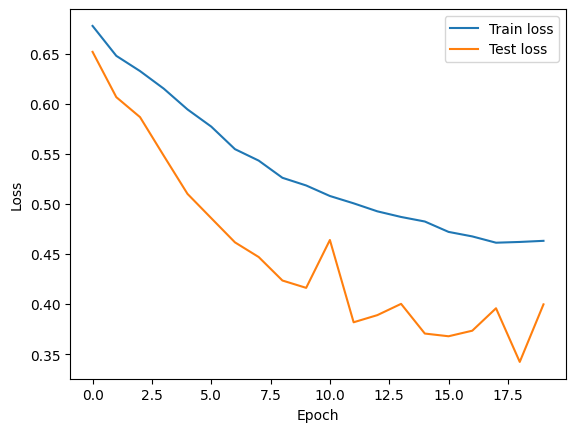

In [9]:
plt.plot(history['train'], label='Train loss')
plt.plot(history['test'], label = 'Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluation

Finally, we will evaluate the model on the test set and print the classification accuracy.

In [10]:
perf_eval = Evaluator(test_ds, batch_size=128)
perf_eval.add_metric("accuracy", binary_accuracy)
metrics = perf_eval.evaluate(model)

print(f"Test Accuracy: {metrics['accuracy']:.2%}")

Test Accuracy: 81.84%


## Summary

In this notebook, we have learned how to use data augmentation in PyTorch. We have seen how to create an augmentation pipeline and apply it to a subset of the available data. We have also trained a simple CNN model on the cats-vs-dogs dataset using data augmentation.

An important point to remember is that data augmentation is applied dinamically during training. This means that the images are transformed "on-the-fly" when a batch is sampled from the dataset. In this scenario, **the model sees a different transformation of the image at each epoch, and the transformations are never saved to disk.** 

Data augmentation is a powerful technique to increase the diversity of the training data and improve the generalization of the model. However, it is important to be careful with the choice of transformations, as some of them may not be suitable for the problem at hand. For example, flipping an image horizontally may not be a good idea for a dataset of handwritten digits. PyTorch provides a wide range of transformations that can be combined to create complex augmentation pipelines. But if you need more advanced augmentations, you can use specialized libraries like [Albumentations](https://albumentations.ai).

You may still be wondering, “How do people who train state-of-the-art models use image augmentation?” The following table shows the data augmentation techniques used in some popular models.

| Model | Data Augmentations |
| --- | --- |
| LeNet-5 | Translate, Scale, Squeeze, Shear |
| AlexNet | Translate, Flip, Intensity Changing |
| ResNet | Crop, Flip |
| DenseNet | Flip, Crop, Translate |
| MobileNet | Crop, Elastic distortion |
| NasNet | Cutout, Crop, Flip |
| ResNeSt | AutoAugment, Mixup, Crop |
| DeiT | AutoAugment, RandAugment, Random erasing, Mixup, CutMix |
| Swin Transformer | RandAugment, Mixup, CutMix, Random erasing |
| U-Net | Translate, Rotate, Gray value variation, Elastic deformation |
| Faster R-CNN | Flip |
| YOLO | Scale, Translate, Color space |
| SSD | Crop, Resize, Flip, Color Space, Distortion |
| YOLOv4 | Mosaic, Distortion, Scale, Color space, Crop, Flip, Rotate, Random erase, Cutout, Hide and Seek, GridMask, Mixup, CutMix, StyleGAN |
